# Fraud Detection 
The project aims to detect fraudulent transaction. The details regarding the data used for the project can be found here: https://www.kaggle.com/c/fraud-detection-analysis The data provided was synthetically generated over a period of time.

In [37]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [4]:
# Renaming the columns and viewing the data

data = data.rename(mapper={'nameOrig': 'name_org', 'oldbalanceOrg': 'old_balance_org', 'newbalanceOrig': 'new_balance_org', 'nameDest': 'name_dest', 'oldbalanceDest': 'old_balance_dest', 'newbalanceDest': 'new_balance_dest',
                   'isFraud': 'is_fraud', 'isFlaggedFraud': 'is_flagged_fraud'}, axis=1)

data.head()

,step,type,amount,name_org,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
# Checking size of data

data.shape[0]

6362620

In [21]:
# Checking distribution of classes

print(data['is_fraud'].value_counts())

print(f"\nPercentage of class 1 points: {round(data['is_fraud'].value_counts().get(1) / data.shape[0] * 100, 2)}")

0    6354407
1       8213
Name: is_fraud, dtype: int64

Percentage of class 1 points: 0.13


#### Observations:
* There are over 6 million data points
* The data is severely imbalanced with class 1 points (fraud) having only 0.13% representation
* Using something like accuracy will be misleading and thus something like precision/recall will be more beneficial

## Description of the features

<b>step</b> - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

<b>type</b> - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

<b>amount</b> -
amount of the transaction in local currency.

<b>nameOrig</b> - customer who started the transaction

<b>oldbalanceOrg</b> - initial balance before the transaction

<b>newbalanceOrig</b> - new balance after the transaction

<b>nameDest</b> - customer who is the recipient of the transaction

<b>oldbalanceDest</b> - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

<b>newbalanceDest</b> - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

<b>isFraud</b> - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

<b>isFlaggedFraud</b> - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [23]:
# Checking for missing data

data.isna().sum()

step                0
type                0
amount              0
name_org            0
old_balance_org     0
new_balance_org     0
name_dest           0
old_balance_dest    0
new_balance_dest    0
is_fraud            0
is_flagged_fraud    0
dtype: int64

There is no missing data so thats one good thing

# Exploratory Data Analysis

In [5]:
# Extracting the fraud data separately

fraud_data = data[data['is_fraud'] == 1]
not_fraud_data = data[data['is_fraud'] == 0]

#### Distribution of 'is_fraud' 

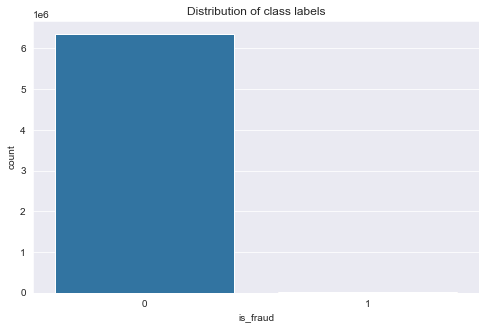

In [149]:
# Here, 0 --> Not Fraud 
#       1 --> Fraud Transaction

plt.figure(figsize=(8,5))
plt.title("Distribution of class labels")
sns.countplot(data['is_fraud']);

The class imbalance is very evident

#### Distribution of the feaure 'type'

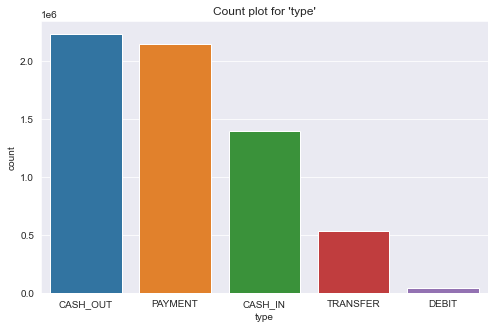

In [150]:
plt.figure(figsize=(8,5))
plt.title("Count plot for 'type'")
sns.countplot(data['type'], order=data['type'].value_counts().index);

In [151]:
# Checking the value_counts

data['type'].value_counts(normalize=True)

CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: type, dtype: float64

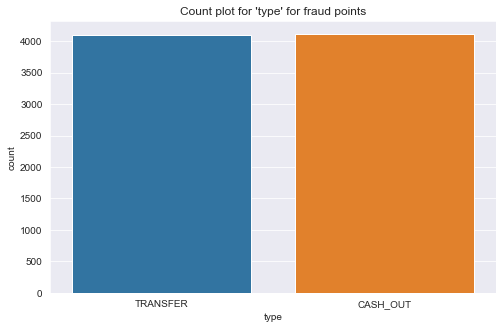

In [152]:
# Checking distribution of transaction types for fraudulent data

plt.figure(figsize=(8,5))
plt.title("Count plot for 'type' for fraud points")
sns.countplot(fraud_data['type']);

#### Observation:
* The 'type' feature has 5 features: Payment, Transfer, Cash Out, Debit and Cash In. This refers to the type of transaction that was made
* Payment (33%), Cash-Out (35%) and Cash-In (22%) are the most common methods of transaction and make up for almost 90% of the transactions that were made
* Transfer (8.3%) and Debit (0.6%) make up for the remaining transactions. The number of transactions by debit are very few in comparision to other modes of trasactions (about 41,432)
* Also most importantly, in the data thats given, all fraud transactions only occur in 'Transfer' and 'Cash-Out' transaction types

#### Analyzing 'Amount'

In [153]:
(data['amount']).describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

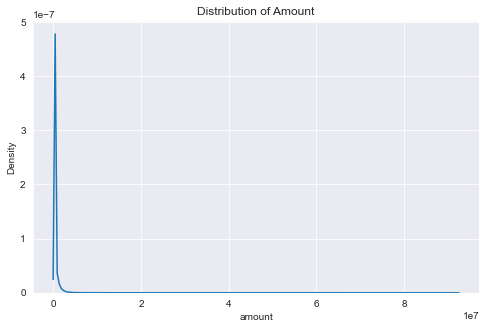

In [154]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='amount')
plt.title('Distribution of Amount');

* The distribution for amount is very skewed. Thus median would give us a better idea over mean

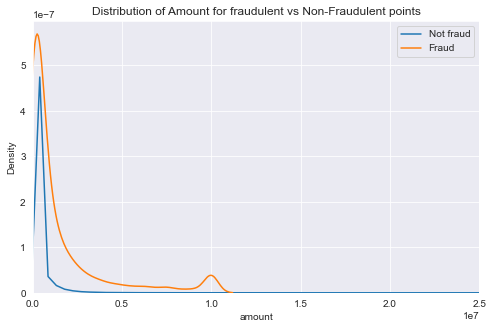

In [155]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=not_fraud_data, x='amount', label='Not fraud')
sns.kdeplot(data=fraud_data, x='amount', label='Fraud')
plt.xlim(0,25000000) # Only checking uptil 25 million
plt.legend()
plt.title('Distribution of Amount for fraudulent vs Non-Fraudulent points')
plt.show()

In [156]:
# Comparing medians of the fraud points with median of the not fraud points

print(f"Median Amount for the Fraud points: {fraud_data['amount'].median()}")
print(f"Median Amount for the Non-Fraud points: {not_fraud_data['amount'].median()}")

Median Amount for the Fraud points: 441423.44
Median Amount for the Non-Fraud points: 74684.72


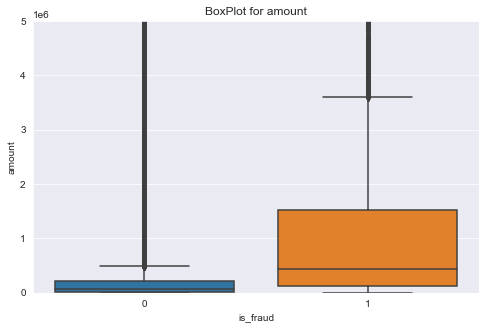

In [157]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_fraud', y='amount', data=data)
plt.ylim(0,5000000);  # Only seeing points bw the the range of 0 - 5 Million
plt.title('BoxPlot for amount')
plt.show()

#### Observations:
* From the distributions, its clear that Amount is extremely right skewed
* The median amount of a Non-Fraudulent transaction is 74,684 whereas for a Fraudulent transaction, it is 441,423
* This means that a typical Fraudulent transaction is likely to be 6 times larger than a Non-Fraudulent Transaction

In [158]:
# Checking the 90-100th percentiles

percentiles = np.arange(90,101)
for p in percentiles:
    percentile = round(np.percentile(data['amount'], p), 2)
    print(f"The {p}th percentile for Amount is {percentile}")

The 90th percentile for Amount is 365423.31
The 91th percentile for Amount is 384851.54
The 92th percentile for Amount is 407811.53
The 93th percentile for Amount is 435529.14
The 94th percentile for Amount is 470779.97
The 95th percentile for Amount is 518634.2
The 96th percentile for Amount is 594003.1
The 97th percentile for Amount is 736427.07
The 98th percentile for Amount is 1019957.81
The 99th percentile for Amount is 1615979.47
The 100th percentile for Amount is 92445516.64


In [159]:
# Expanding the 99-100 percentile region

percentiles = np.arange(990,1001)/10
for p in percentiles:
    percentile = round(np.percentile(data['amount'], p), 2)
    print(f"The {p}th percentile for Amount is {percentile}")
print()  # Blank space

The 99.0th percentile for Amount is 1615979.47
The 99.1th percentile for Amount is 1723310.59
The 99.2th percentile for Amount is 1850371.65
The 99.3th percentile for Amount is 2002969.79
The 99.4th percentile for Amount is 2189824.12
The 99.5th percentile for Amount is 2437745.64
The 99.6th percentile for Amount is 2793682.59
The 99.7th percentile for Amount is 3365559.25
The 99.8th percentile for Amount is 4566795.32
The 99.9th percentile for Amount is 8956797.68
The 100.0th percentile for Amount is 92445516.64



* It looks like 99.9% of Amount lies below $9 million

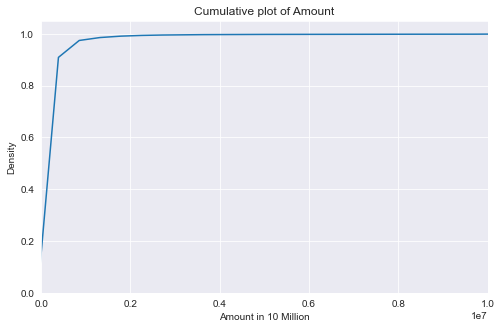

In [160]:
# Cumulative plot for Amount

plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='amount', cumulative=True)
plt.xlim(0,10000000)  # Checking only upto 10 million dollars
plt.xlabel('Amount in 10 Million')
plt.title('Cumulative plot of Amount');

* Expaning on previous analysis, the cumulative plot confirms that only 0.1% datapoints lie above 9 million USD
* Similarly, only 5% datapoints have amount greater than 500,000 USD or 0.5 million USD

0.11226171056925069


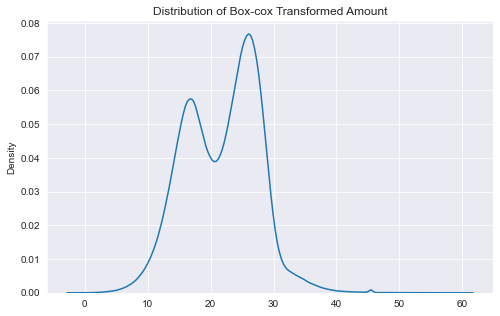

In [6]:
transformed_amount, lmbda = sp.stats.boxcox(data['amount']+0.1)

plt.figure(figsize=(8,5))
sns.kdeplot(transformed_amount)
plt.title('Distribution of Box-cox Transformed Amount');

print(lmbda)

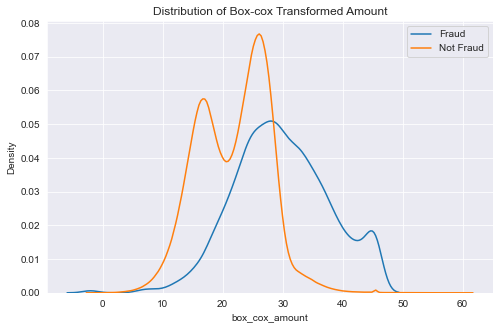

In [7]:
data['box_cox_amount'] = transformed_amount

plt.figure(figsize=(8,5))
sns.kdeplot(data[data['is_fraud']==1]['box_cox_amount'], label='Fraud')
sns.kdeplot(data[data['is_fraud']==0]['box_cox_amount'], label='Not Fraud')
plt.title('Distribution of Box-cox Transformed Amount')
plt.legend();

#### Exploring name origin (name_org) and name destination (name_dest)
name_org feature is the name/identity of the customer who started the transaction and name_dest feature is the identity of the customer to whom the fund was transacted

In [8]:
# Checking the number of unique values in name_org

data['name_org'].nunique()

6353307

In [9]:
# Checking the number of unique values in name_org

data['name_dest'].nunique()

2722362

In [10]:
print(f"Percentage of Unique Users (Origin):      {round(6353307/data.shape[0] * 100,2)}")
print(f"Percentage of Unique Users (Destination): {round(2722362/data.shape[0] * 100,2)}")

Percentage of Unique Users (Origin):      99.85
Percentage of Unique Users (Destination): 42.79


In [11]:
# Since it'll be hard to featurize these two features as they have way too many unique values, one thing that can be tried is to use the first letter of these IDs

print(f"Unique first letters in Name-Origin: {data['name_org'].apply(lambda x: x[0]).unique()}")
print(f"Unique first letters in Name-Destination: {data['name_dest'].apply(lambda x: x[0]).unique()}")

Unique first letters in Name-Origin: ['C']
Unique first letters in Name-Destination: ['M' 'C']


#### Observation:
* For name-origin, the first letters for all IDs is 'C' whereas for name-destination, there are 2 unique letters: 'C' and 'M'
* Since there are way too unique name-origins, its better to drop the feature. We can extract the first letter from name-destination and drop the original feature itself

In [12]:
# Checking how the new feature is distributed in the entire data

data['name_dest'].apply(lambda x: x[0]).value_counts(normalize=True)

C    0.661854
M    0.338146
Name: name_dest, dtype: float64

In [13]:
# Checking how the new feature is distributed for only the fraudulent data

fraud_data['name_dest'].apply(lambda x: x[0]).value_counts(normalize=True)

C    1.0
Name: name_dest, dtype: float64

#### Observation
* In the data, name destination with starting letter 'C' occurs 66% times and starting with 'M' occurs 33% times
* Whereas for the fraudulent data, all points lead to destinations starting with the letter 'C'

In [14]:
# Dropping the name_dest and name_org and replacing name_dest with the new feature containing the first letter only

data['name_dest'] = data['name_dest'].apply(lambda x: x[0])  # Replaces the entire name of the destination with only the first letter
data.drop('name_org', axis=1, inplace=True)  # Dropping name_org

In [17]:
data.head()

,step,type,amount,old_balance_org,new_balance_org,name_dest,old_balance_dest,new_balance_dest,is_fraud,is_flagged_fraud,box_cox_amount
0,1,PAYMENT,9839.64,170136.0,160296.36,M,0.0,0.0,0,0,16.097281
1,1,PAYMENT,1864.28,21249.0,19384.72,M,0.0,0.0,0,0,11.837754
2,1,TRANSFER,181.00,181.0,0.00,C,0.0,0.0,1,0,7.060082
3,1,CASH_OUT,181.00,181.0,0.00,C,21182.0,0.0,1,0,7.060082
4,1,PAYMENT,11668.14,41554.0,29885.86,M,0.0,0.0,0,0,16.580335


#### Analyzing old_balance_org and new_balance_org

Since 'amount' represents the transaction value, it should mean that the difference between old_balance_org and new_balance_org should be the same

In [46]:
# Calculating absolute difference in the old and new balance for the origin

diff = abs(data['old_balance_org'] - data['new_balance_org'])

In [47]:
print(f"Amount is not equal to absolute difference bw old and new balance for {round((diff!= data['amount']).sum() / data.shape[0] *100, 2)}% points\n")

Amount is not equal to absolute difference bw old and new balance for 85.4% points



#### Observation:
* The value in amount differs for over 93% points
* One feature that can be used is this difference between the actual amount and the absolute difference bw old and the new balance

In [49]:
data['amount_diff'] = diff - data['amount_diff']
data['amount_diff'].describe()

count    6.362620e+06
mean     2.753890e+05
std      6.709391e+05
min     -1.000000e-02
25%      3.000557e+03
50%      7.755063e+04
75%      3.151444e+05
max      9.244552e+07
Name: amount_diff, dtype: float64

In [51]:
data['amount_diff'].head()

0   -1.455192e-11
1    1.136868e-12
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
Name: amount_diff, dtype: float64

## Feature Engineering based on observations


In [57]:
data['name_dest_M_flag'] = data['name_dest'].apply(lambda x: 1 if x == 'M' else 0)
data['name_dest_C_flag'] = data['name_dest'].apply(lambda x: 1 if x == 'C' else 0)

# Since the type for fraudulent data is only transfer or cash out
data['transfer_flag'] = data['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)
data['cash_out_flag'] = data['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)

data = data.drop(['type', 'step', 'name_dest', 'is_flagged_fraud', 'box_cox_amount'] ,axis=1)

In [58]:
data.head()

,amount,old_balance_org,new_balance_org,old_balance_dest,new_balance_dest,is_fraud,amount_diff,name_dest_M_flag,name_dest_C_flag,transfer_flag,cash_out_flag
0,9839.64,170136.0,160296.36,0.0,0.0,0,-1.455192e-11,1,0,0,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,1.136868e-12,1,0,0,0
2,181.00,181.0,0.00,0.0,0.0,1,0.000000e+00,0,1,1,0
3,181.00,181.0,0.00,21182.0,0.0,1,0.000000e+00,0,1,0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0,0.000000e+00,1,0,0,0


In [ ]:
data.to_csv('new_data', index=False)

In [3]:
data=pd.read_csv('new_data')

## Splitting the dataset

I'll try experimenting with 70:30 split

In [5]:
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
print(f"Number of fraudulent points in the Test set: {(y_test == 1).sum()} out of {(data['is_fraud']==1).sum()} points")

Number of fraudulent points in the Test set: 2464 out of 8213 points


## Setting evaluation metrics

## Modelling

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
%%time 

# Training the model on the train data

# Trying without balancing class weights
clf = RandomForestClassifier(n_estimators=100, n_jobs=6)

clf.fit(X_train, y_train)

Wall time: 2min 34s


RandomForestClassifier(n_jobs=6)

In [43]:
clf_pred_test = clf.predict(X_test)
clf_pred_train = clf.predict(X_train)

In [28]:
# Recall on train data

print(f"Recall on train data: {recall_score(y_train, clf_pred_train)}")
print(f"Recall on test data: {recall_score(y_test, clf_pred_test)}")

Recall on train data: 1.0
Recall on test data: 0.9963474025974026


In [44]:
# Confusion matrix for the training data

confusion_matrix(y_test, clf_pred_test)

array([[1906322,       0],
       [      9,    2455]], dtype=int64)

In [30]:
# Confusion matrix for the test data

confusion_matrix(y_train, clf_pred_train)

array([[4448085,       0],
       [      0,    5749]], dtype=int64)

In [46]:
X_train.columns

Index(['amount', 'old_balance_org', 'new_balance_org', 'old_balance_dest',
       'new_balance_dest', 'amount_diff', 'name_dest_M_flag',
       'name_dest_C_flag', 'transfer_flag', 'cash_out_flag'],
      dtype='object')

In [45]:
clf.feature_importances_

array([0.08166994, 0.07659933, 0.41796923, 0.02334517, 0.12618502,
       0.23293746, 0.00066418, 0.00131055, 0.02558468, 0.01373444])

* From the analysis of the feature importance scores, we can say that the top 3 features that helped the most with detecting a fraud are as follows (in decreasing order of importance):<br>
1. 'new_balance_org'
2. 'amount_diff'
3. 'new_balance_dest'


In [33]:
%%time 

# Training the model on the train data

# Trying with balancing of class weights
clf_balanced = RandomForestClassifier(n_estimators=100, n_jobs=6, class_weight='balanced')

clf_balanced.fit(X_train, y_train)

Wall time: 2min 19s


RandomForestClassifier(class_weight='balanced', n_jobs=6)

In [34]:
clf_pred_test_balanced = clf_balanced.predict(X_test)
clf_pred_train_balanced = clf_balanced.predict(X_train)

In [35]:
# Confusion matrix for the training data

confusion_matrix(y_train, clf_pred_train_balanced)

array([[4448085,       0],
       [      0,    5749]], dtype=int64)

In [36]:
# Confusion matrix for the test data

confusion_matrix(y_test, clf_pred_test_balanced)

array([[1906322,       0],
       [      9,    2455]], dtype=int64)

# Conclusion and takeaways
* The challenge with the data revolved around the severe imbalance which was easily managaed by the Random Forest Classifier since tree based classifiers are robust to imabalance in the classes.
* The priority was to obtain an optimum recall score and that was very well done with the help of a Random Forest Classifier and a bit of Exploratory Data Analysis.
* Balancing the class weights doesn't have any impact on model performance.
* To further understand the performance of the model, a k-fold score can be beneficial.